# E91 Quanten-Schlüsselaustausch mit Qiskit

In diesem Notebook demonstrieren wir das **E91-Protokoll** nach Ekert (1991), indem wir **Qiskit** verwenden, um:
1. Einen **Singulett-Zustand** (Bell-Zustand) zu erzeugen
2. Diesen in verschiedenen Basen zu **messen**
3. Die **CHSH-Korrelation** (zur Eavesdropping-Erkennung) zu bestimmen
4. Und mit **Bloch-Kugel-Darstellungen** anschaulich zu machen, wie die Zustände aussehen

## Inhalt
1. [Einleitung zum E91-Protokoll](#einleitung)
2. [E91-Algorithmus](#algorithmus)
3. [Unterschied zum BB84](#unterschiede)
4. [CHSH Ungleichung](#chsh)
4. [Vorbereitung: Importe und Simulator](#vorbereitung)
5. [Erzeugung des Singulett-Zustands](#singulett)
6. [Bloch-Kugel-Visualisierungen](#bloch)
7. [Messungen in verschiedenen Basen & CHSH-Test](#messungen)
8. [E91-Schlüsselerzeugung](#schluessel)
9. [Fazit zum E91](#fazit)

<a id="einleitung"></a>
## 1. Einleitung zum E91-Protokoll

Das **E91-Protokoll** (auch *Ekert-91* genannt) wurde 1991 von dem Physiker **Artur Ekert** vorgestellt und war ein bedeutender Meilenstein in der Entwicklung der *Quantum Key Distribution (QKD)*. Im Gegensatz zu früheren QKD-Schemata (wie **BB84**, 1984 von Bennett und Brassard publiziert) nutzt E91 **verschränkte Teilchen** und den **Bell-Test** (konkret die *CHSH-Ungleichung*) zur Absicherung.

#### Kurzer geschichtlicher Überblick
- In den 1960er-Jahren entwickelte **John Bell** die *Bell-Ungleichungen*, die zeigen, wie sich die Vorhersagen der Quantenmechanik von denen *lokalrealistischer* Theorien unterscheiden.
- Die Version dieser Ungleichungen, die sich experimentell besonders gut testen lässt, ist die **CHSH-Ungleichung** (Clauser, Horne, Shimony, Holt, 1969).
- **Ekert** erkannte, dass man genau diese *nichtklassische Verschränkung* nicht nur als kurioses Phänomen der Quantenphysik, sondern auch zur *Schlüsselverteilung* nutzen kann. Dadurch entstand das E91-Protokoll.

Durch die Verwendung von *verschränkten Photonenpaaren* kann man zeigen, dass jedes Abhörmanöver die Verschränkungs-Korrelationen stört und damit *messbar* wird. Genau auf diesem Prinzip beruht die Sicherheit des Verfahrens.

#### Einsatz in der Realität
- **2008**: Alexander Ling und Kollegen implementierten das E91-Protokoll in einer Freiraumumgebung mit verschränkten Photonenpaaren. Sie nutzten die Verletzung der Clauser-Horne-Shimony-Holt (CHSH)-Ungleichung zur Sicherstellung der Schlüsselverteilung. 

- **2015**: Mikio Fujiwara und sein Team demonstrierten eine modifizierte Version des E91-Protokolls mit einer hybriden Verschränkungsquelle, die Zeit-Bin-Qubits bei 1550 nm und Polarisations-Qubits bei 810 nm kombinierte. Die CHSH-Ungleichung wurde für die Verschränkung zwischen dem Polarisations-Qubit im freien Raum und dem Zeit-Bin-Qubit über eine 20 km lange Faserübertragung verletzt. Die sichere Schlüsselrate wurde auf 70-150 Bit pro Sekunde geschätzt. 

- **2017**: Erstmals gelang es, einen Quantenschlüssel von einem Satelliten zur Erde über eine Distanz von ca. 1200 km zu übertragen. Das Vakuum im Weltall minimiert dabei die Schwächung der Photonen und reduziert Dekohärenz.

<a id="algorithmus"></a>
## 2. E91-Algorithmus

Der **E91-Algorithmus** beschreibt ein *Schlüsselverteilungsverfahren* zwischen zwei Parteien, die wir wie üblich **Alice** und **Bob** nennen. Die wesentliche Neuerung gegenüber BB84 ist, dass E91 auf **verschränkte Photonen** setzt, die von einer Quelle (manchmal "Charlie" genannt) verteilt werden.

Im Folgenden findest du eine **schrittweise und ausführliche** Darstellung – auch für diejenigen, die mit Quantencomputing bislang nur *Basiskonzepte* (z.B. Qubits, einfache Quantenoperationen) vertraut sind.

### 2.1 Grundidee

1. **Erzeugung verschränkter Photonen-Paare**
   - Eine Quantenquelle (z.B. ein Kristall für Spontaneous Parametric Down-Conversion) produziert *Paare von Photonen*, die sich im sog. *Bell-Zustand* befinden. 
   - Einer der am häufigsten verwendeten Bell-Zustände ist $|\Phi^+\rangle = \tfrac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$. 
   - *Verschränkt* bedeutet hier, dass die Photonen so miteinander korreliert sind, dass man ihren gemeinsamen Zustand nicht als Produkt zweier Einzelzustände beschreiben kann.

2. **Verteilung an Alice und Bob**
   - Von jedem erzeugten Photonenpaar erhält Alice das erste Photon und Bob das zweite Photon, typischerweise über Glasfasern oder freiraumoptische Systeme.
   - Wichtig ist: Sie müssen *räumlich* getrennt sein, damit man die *Korrelationen* auch nicht-klassisch messen kann.

3. **Zufällige Messbasen**
   - Alice und Bob wählen (unabhängig voneinander) zufällig aus *mehreren* möglichen Messbasen. Beispielsweise kann Alice zwischen zwei Winkeln $A$ und $A'$ wählen, Bob zwischen zwei Winkeln $B$ und $B'$. 
   - In der Praxis (z.B. Photonen mit Polarisationszuständen) könnte das bedeuten, dass Alice einmal *horizontale/vertikale* Basis und ein anderes Mal *diagonale* Basis verwendet, Bob ebenso. 

4. **Messung & Korrelation**
   - Alice misst *ihr* Photon in ihrer gewählten Basis (z.B. in $A$ oder $A'$). 
   - Bob misst *sein* Photon in $B$ oder $B'$.
   - Weil der Gesamtzustand *verschränkt* ist, werden die Messergebnisse *statistisch korreliert* sein – genauer gesagt, sie können *Bell-Korrelationen* erfüllen.

5. **Klassische Kommunikation & Basisabgleich**
   - Alice und Bob kommunizieren *klassisch* (z.B. über Telefon oder Internet) und vergleichen **nur** ihre *gewählten Basen*, *nicht* ihre Messergebnisse.
   - Für Schlüsselzwecke behalten sie nur jene Durchläufe, in denen sie *gleiche* Messbasen verwendet haben. Bei E91 ist das zum Teil flexibel, je nach Ausgestaltung kann man verschiedene Basen-Konfigurationen verwalten.

6. **Bell-Test (CHSH-Test)**
   - Ein *zentraler Teil* von E91 ist, dass Alice und Bob einen Teil ihrer Messdaten (nicht alle) heranziehen, um zu überprüfen, ob sich die Messergebnisse wirklich "nicht-klassisch" verhalten.
   - Hierzu berechnen sie den **CHSH-Parameter** $S$ (siehe Abschnitt 3) aus jenen Messungen, bei denen *Alice verschiedene Einstellungen* ($A$, $A'$) und *Bob verschiedene Einstellungen* ($B$, $B'$) gewählt haben.
   - **Wenn** $|S|>2$ signifikant verletzt wird, zeigt das, dass die *lokalrealistischen* Grenzen überschritten werden. Das heißt: Die Photonen *sind echt verschränkt*. 
   - Tritt diese Verletzung **nicht** auf, ist es wahrscheinlich, dass jemand (Eve) sich eingeklinkt und damit die Verschränkung zerstört hat.

7. **Schlüsselerzeugung**
   - Jene Daten, die *nicht* für den CHSH-Test genutzt werden, dienen der **Schlüsselerzeugung**.
   - Alice und Bob führen noch **Fehlerkorrektur** (z.B. Cascade, LDPC oder andere Protokolle) und **Privacy Amplification** durch, um kleine Fehler zu beseitigen und die Sicherheit zu erhöhen.

### 2.2 Warum ist das so sicher?
1. **Verschränkung**: Sobald jemand versucht, an den Photonen herumzumessen, um an Informationen zu gelangen, wird die *Verschränkung* gestört.
2. **CHSH-Ungleichung**: Die *Korrelationswerte* fallen unter ein bestimmtes Niveau, wenn klassische (oder *lokalrealistische*) Einflüsse ins Spiel kommen. 
3. **Entdeckung von Abhörern**: Misslingt der Bell-Test, wissen Alice und Bob: Da stimmt etwas nicht, vermutlich ist ein Lauscher am Werk.
4. **Abbruch**: Bei Verdacht brechen Alice und Bob das Protokoll ab und verwerfen die Daten.

So stellt das E91-Protokoll eine extrem solide und *prinzipiell* abhörsichere Methode dar, da es auf ganz fundamentalen Prinzipien der Quantenphysik – *Verschränkung* und *Bell-Tests* – beruht.

### 2.3 Ein gültiger Schlüsselaustausch zwischen Alice und Bob

In [2009]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import pandas as pd

n = 10
seed = 42

computational_basis = computational_basis  # Z-Basis
hadamard_basis =      hadamard_basis  # X-Basis

# np.random.seed(seed)
alice_bases = np.random.choice([hadamard_basis, computational_basis], size=n) 
bob_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
alice_bits = np.random.randint(2, size=n)

aer_simulator = AerSimulator()

alice_results = []
bob_results = []

for i in range(n):
    qreg = QuantumRegister(2, f'q{i}')
    creg = ClassicalRegister(2, f'c{i}')
    circuit = QuantumCircuit(qreg, creg)
    
    circuit.h(qreg[0])
    circuit.cx(qreg[0], qreg[1])

    if alice_bases[i] == hadamard_basis:
        circuit.h(qreg[0])
    circuit.measure(qreg[0], creg[0])

    if bob_bases[i] == hadamard_basis:
        circuit.h(qreg[1])
    circuit.measure(qreg[1], creg[1])

    result = aer_simulator.run(circuit, shots=1).result()
    counts = result.get_counts()

    for outcome in counts:
        alice_results.append(int(outcome[-1]))
        bob_results.append(int(outcome[-2]))
matching_bases = [alice_bases[i] == bob_bases[i] for i in range(n)]
key = [alice_results[i] for i in range(n) if matching_bases[i]]
data = {
    "Bits from Alice    ": alice_results,
    "  Bases from Alice    ": alice_bases,
    " ": [
        f"    \033[92m{"----->"}\033[0m" if matching_bases[i] else f"\033[91m{"----->"}\033[0m"
        for i in range(n)
    ],
    "  Bits from Bob    ": bob_results,
    "  Bases from Bob    ": bob_bases,
    "    Matching Bits         ": [
        f"    \033[92m{alice_results[i]}\033[0m" if matching_bases[i] else f"\033[91m{bob_results[i]}\033[0m"
        for i in range(n)
    ],
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

 Bits from Alice       Bases from Alice                            Bits from Bob       Bases from Bob         Matching Bits         
                   0                      Z     ----->                    1                    X                 1
                   0                      X     ----->                    0                    Z                 0
                   1                      Z     ----->                    1                    Z                 1
                   0                      Z     ----->                    0                    Z                 0
                   0                      Z     ----->                    0                    Z                 0
                   1                      Z     ----->                    1                    Z                 1
                   0                      Z     ----->                    0                    X                 0
                   1                      Z     ----->        

### 2.4 Ein Schlüsselautausch mit einem Eavesdropper

In [2010]:
def bb84_with_eavesdropper(n):
    # Alice, Bob und Eve
    alice_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
    bob_bases = np.random.choice([hadamard_basis, computational_basis], size=n)
    eve_bases = np.random.choice([hadamard_basis, computational_basis], size=n)

    aer_simulator = AerSimulator()

    alice_results = []
    bob_results = []
    eve_results = []
    eve_detected = []

    for i in range(n):
        qreg = QuantumRegister(1, f'q{i}')
        creg = ClassicalRegister(1, f'c{i}')
        circuit = QuantumCircuit(qreg, creg)

        # Alice präpariert Qubit
        if alice_bits[i] == 1:
            circuit.x(qreg[0])
        if alice_bases[i] == hadamard_basis:
            circuit.h(qreg[0])

        # Eve misst
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])
        eve_result = aer_simulator.run(circuit, shots=1).result()
        eve_outcome = int(list(eve_result.get_counts().keys())[0][0])
        eve_results.append(eve_outcome)

        # Eve präpariert das Qubit neu
        if eve_outcome == 1:
            circuit.x(qreg[0])
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])

        # Bob misst
        if bob_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])

        result = aer_simulator.run(circuit, shots=1).result()
        bob_outcome = int(list(result.get_counts().keys())[0][0])
        alice_results.append(alice_bits[i])
        bob_results.append(bob_outcome)

        # Detektionsprüfung
        eve_detected.append(
            alice_bases[i] == bob_bases[i] and alice_results[-1] != bob_results[-1]
        )

    matching_bases = [alice_bases[i] == bob_bases[i] for i in range(n)]
    data = {
        "Bits from Alice    ": alice_results,
        "Bases from Alice    ": alice_bases,
        " ": [
            f"    \033[92m{"----->"}\033[0m" if matching_bases[i] else f"\033[91m{"----->"}\033[0m"
            for i in range(n)
        ],
        "Bits from Eve       ": eve_results,
        "Bases from Eve      ": eve_bases,
        "  ": [
            f"    \033[92m{"----->"}\033[0m" if matching_bases[i] else f"\033[91m{"----->"}\033[0m"
            for i in range(n)
        ],
        "Bits from Bob       ": bob_results,
        "Bases from Bob      ": bob_bases,
        "Matching Bits         ": [
            f"                         \033[92m{alice_results[i]}\033[0m" if matching_bases[i] else f"\033[91m{bob_results[i]}\033[0m"
            for i in range(n)
        ],
        "              Eve Detected?       ": ["Yes" if eve_detected[i] else "No" for i in range(n)],
    }

    df = pd.DataFrame(data)
    detected_rate = sum(eve_detected) / n * 100

    return df, detected_rate


# Simulation mit Wiederholungen
def run_simulation(n_bits, repeats):
    results = []
    detection_rates = []

    c = 0
    for _ in range(repeats):
        df, detected_rate = bb84_with_eavesdropper(n_bits)
        if detected_rate <= 0.0:
            c += 1
        results.append(df)
        detection_rates.append(detected_rate)

    avg_detection_rate = np.mean(detection_rates)

    # Anzeige des letzten Durchgangs
    print("\nLetzte Iteration:")
    print(results[-1].to_string(index=False))
    print(f"\nDurchschnittliche Entdeckungsrate über {repeats} Wiederholungen: {avg_detection_rate:.2f}%")
    print(f"Anzahl der Schlüsselaustausche ohne Eve zu bemerken: {c} von {repeats}")


n_bits = 10
repeats = 100
run_simulation(n_bits, repeats)



Letzte Iteration:
 Bits from Alice     Bases from Alice                          Bits from Eve        Bases from Eve                            Bits from Bob        Bases from Bob                    Matching Bits                        Eve Detected?       
                   1                    Z     ----->                     1                    Z     ----->                     0                    X                          0                                 No
                   0                    X     ----->                     0                    Z     ----->                     0                    X                          0                                 No
                   1                    Z     ----->                     0                    X     ----->                     0                    Z                          1                                Yes
                   0                    Z     ----->                     0                    Z     ----->

# E91 with Eavesdropper

Alice's Basis  Alice's Result                     Eve's Basis  Eve's Result                     Bob's Basis  Bob's Result  CHSH Value Eavesdropper Detected?
            Z               0     ----->           X             0     ----->           X             1    1.295238                     No
            X               1     ----->           X             0     ----->           Z             0    1.295238                     No
            X               1     ----->           Z             1     ----->           Z             1    1.295238                     No
            X               0     ----->           X             0     ----->           Z             1    1.295238                     No
            Z               1     ----->           Z             0     ----->           X             0    1.295238                     No
            Z               0     ----->           X             0     ----->           X             1    1.295238                     No
         

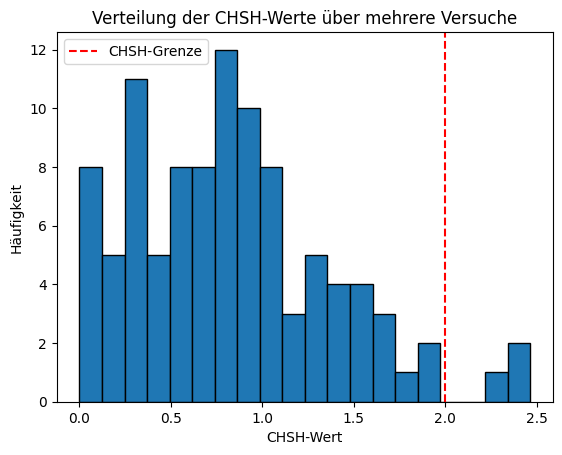

In [2121]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CHSH-Ungleichung korrekt implementiert (nur positive Werte)
def chsh_violation(a_basis, b_basis, outcomes):
    """
    Berechnung des CHSH-Ausdrucks, um Eavesdropping zu erkennen.
    CHSH-Formel: S = |E(a1, b1) - E(a1, b2) + E(a2, b1) + E(a2, b2)|
    """
    E = {(computational_basis, computational_basis): 0, (computational_basis, hadamard_basis): 0, (hadamard_basis, computational_basis): 0, (hadamard_basis, hadamard_basis): 0}
    counts = {(computational_basis, computational_basis): 0, (computational_basis, hadamard_basis): 0, (hadamard_basis, computational_basis): 0, (hadamard_basis, hadamard_basis): 0}

    for basis_pair, result_pair in zip(zip(a_basis, b_basis), outcomes):
        a, b = basis_pair
        result_a, result_b = result_pair

        if (a, b) in E:
            counts[(a, b)] += 1
            E[(a, b)] += 1 if result_a == result_b else -1

    # Durchschnittliche Korrelation berechnen
    for key in E.keys():
        if counts[key] > 0:
            E[key] /= counts[key]

    # CHSH-Ausdruck berechnen (nur positive Werte berücksichtigen)
    S = abs(E[(computational_basis, computational_basis)] - E[(computational_basis, hadamard_basis)] + E[(hadamard_basis, computational_basis)] + E[(hadamard_basis, hadamard_basis)])
    return S

def e91_protocol_with_eavesdropper(n):
    # Simulation initialisieren
    aer_simulator = AerSimulator()

    # Alice, Bob und Eve wählen Zufallsbasen
    alice_bases = np.random.choice([computational_basis, hadamard_basis], size=n)
    bob_bases = np.random.choice([computational_basis, hadamard_basis], size=n)
    eve_bases = np.random.choice([computational_basis, hadamard_basis], size=n)

    # Ergebnisse initialisieren
    alice_results = []
    bob_results = []
    eve_results = []
    outcomes = []

    # Quantenregister und Schaltkreis erstellen
    qreg = QuantumRegister(2, "q")
    creg = ClassicalRegister(2, "c")
    circuit = QuantumCircuit(qreg, creg)

    for i in range(n):
        circuit.reset(qreg)

        # Erzeugung von verschränkten Qubits (Bell-Zustand)
        circuit.h(qreg[0])
        circuit.cx(qreg[0], qreg[1])

        # Eve misst mit ihrer Basis
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])

        eve_result = aer_simulator.run(circuit, shots=1).result()
        eve_counts = eve_result.get_counts()
        eve_outcome = int(list(eve_counts.keys())[0][0])
        eve_results.append(eve_outcome)

        # Qubit neu präparieren basierend auf Eves Ergebnis
        circuit.reset(qreg[0])
        if eve_outcome == 1:
            circuit.x(qreg[0])
        if eve_bases[i] == hadamard_basis:
            circuit.h(qreg[0])

        # Alice misst
        if alice_bases[i] == hadamard_basis:
            circuit.h(qreg[0])
        circuit.measure(qreg[0], creg[0])

        result_a = aer_simulator.run(circuit, shots=1).result()
        alice_counts = result_a.get_counts()
        alice_outcome = int(list(alice_counts.keys())[0][0])
        alice_results.append(alice_outcome)

        # Bob misst
        if bob_bases[i] == hadamard_basis:
            circuit.h(qreg[1])
        circuit.measure(qreg[1], creg[1])

        result_b = aer_simulator.run(circuit, shots=1).result()
        bob_counts = result_b.get_counts()
        bob_outcome = int(list(bob_counts.keys())[0][0])
        bob_results.append(bob_outcome)

        outcomes.append((alice_outcome, bob_outcome))

    # Berechnung der CHSH-Ungleichung
    chsh_value = chsh_violation(alice_bases, bob_bases, outcomes)
    detected = chsh_value >= 2  # Verletzung deutet auf Lauscher hin

    # Daten für Analyse erstellen
    data = {
        "Alice's Basis": alice_bases,
        "Alice's Result": alice_results,
        " ": [
            f"    \033[92m{"----->"}\033[0m" if chsh_value < 2 else f"\033[91m{"----->"}\033[0m"
            for i in range(n)
        ],
        "Eve's Basis": eve_bases,
        "Eve's Result": eve_results,
        "  ": [
            f"    \033[92m{"----->"}\033[0m" if chsh_value < 2 else f"\033[91m{"----->"}\033[0m"
            for i in range(n)
        ],
        "Bob's Basis": bob_bases,
        "Bob's Result": bob_results,
        "CHSH Value": [chsh_value] * n,
        "Eavesdropper Detected?": ["Yes" if detected else "No"] * n
    }

    df = pd.DataFrame(data)

    return df, chsh_value

# Simulation mit Wiederholungen
n_bits = 20
repeats = 100

chsh_values = []

for _ in range(repeats):
    df, chsh_value = e91_protocol_with_eavesdropper(n_bits)
    chsh_values.append(chsh_value)

# Ergebnisse drucken (letzte Iteration)
print(df.to_string(index=False))
print(f"Letzter S-Wert: {chsh_values[-1]:.2f} -> {'Eve wurde bemerkt!' if chsh_values[-1] <= 2 else 'Eve konnte unbemerkt lauschen.'}")
print(f"\nDurchschnittlicher CHSH-Wert über {repeats} Wiederholungen: {np.mean(chsh_values):.2f}")
detected = sum(chsh <= 2 for chsh in chsh_values)
print(f"Eve wurde {detected} von {repeats} entdeckt!")

# Graph erstellen
plt.hist(chsh_values, bins=20, edgecolor="black")
plt.title("Verteilung der CHSH-Werte über mehrere Versuche")
plt.xlabel("CHSH-Wert")
plt.ylabel("Häufigkeit")
plt.axvline(x=2, color="red", linestyle="--", label="CHSH-Grenze")
plt.legend()
plt.show()


<a id="unterschiede"></a>
# 3. Unterschiede zwischen E91 und BB84

1. **Zustandserzeugung**:
   - **BB84**: Alice erzeugt einzelne Photonen in bestimmten Basen (z.B. Horizontal/Vertikal oder Diagonal).
   - **E91**: Es wird eine Quelle *verschränkter* Photonenpaare benötigt.

2. **Sicherheitskonzept**:
   - **BB84**: Beruht vor allem auf der *Unmöglichkeit*, einen unbekannten Quantenzustand perfekt zu kopieren (No-Cloning-Theorem) und der *Zustandsstörung* bei Messung.
   - **E91**: Setzt zusätzlich auf den **CHSH-Test**, um das Vorhandensein echter Verschränkung und damit Nicht-Klassizität zu belegen.

3. **Experimentelle Umsetzung**:
   - **BB84**: Im Labor oder in kommerziellen Systemen relativ gut realisierbar, da man "nur" einzelne Photonen (oder schwache Lichtpulse) in definierten Basen benötigt.
   - **E91**: Erfordert eine *zuverlässige Quelle* für verschränkte Photonenpaare und optische Komponenten, die die Verschränkung möglichst *verlust- und rauschfrei* verteilen.

4. **Verbreitung**:
   - **BB84**: Das "Klassiker-Protokoll" und z.B. in den meisten frühen QKD-Demonstrationen verwendet.
   - **E91**: Konzeptionell sehr elegant und in der Grundlagenforschung hochinteressant, weil es *direkt* Bell-Tests einschließt.

<a id="vorbereitung"></a>
## 4. Vorbereitungen: Importe und Simulator

Wir verwenden hier den **AerSimulator** aus `qiskit_aer`. Zudem laden wir Visualisierungstools wie `plot_bloch_multivector` und `plot_histogram`. Das `%matplotlib inline`-Magic-Befehl sorgt dafür, dass unsere Plots direkt im Notebook erscheinen.
Zusätzliche Pakete können je nach Bedarf installiert oder importiert werden (z.B. `qiskit.tools.jupyter`).

In [2122]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector, plot_histogram

%matplotlib inline
simulator = AerSimulator()

Die folgende Funktion `correlation` wird später gebraucht, um aus **Zählstatistiken** (gemessenen Counts) Korrelationen zu berechnen. Das hilft uns insbesondere bei der Auswertung des CHSH-Parameters.

Erwartungswert $E = ( (00 + 11) - (01 + 10))\ /\ $ Summe aller counts

Interpretation:
- Qubit 0 -> Bit a
- Qubit (1) -> Bit b
- 0 => +1, 1 => -1

In [2123]:
def correlation(counts):
    shots = sum(counts.values())
    c00 = counts.get('00', 0)
    c11 = counts.get('11', 0)
    c01 = counts.get('01', 0)
    c10 = counts.get('10', 0)
    return ((c00 + c11) - (c01 + c10)) / shots

<a id="singulett"></a>
## 5. Erzeugung des Singulett-Zustands

Der Singulett-Zustand $(|\psi^-\rangle)$ gehört zu den vier Bell-Zuständen und kann (bis auf globale Phasen) wie folgt geschrieben werden:
$|\psi^-\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle).$

Um ihn in Qiskit zu erzeugen, genügt meist eine kurze Sequenz von Gattern:
1. Wir wandeln das zweite Qubit (Index 1) in den Zustand $|1\rangle$ per X-Gatter.
2. Wir legen am ersten Qubit (Index 0) ein Hadamard an.
3. Wir führen ein CNOT(0->1) aus.
4. Wir legen eine Z-Operation auf das zweite Qubit an (um die relative Phase herzustellen).

Damit wird der Zustand $(|01> - |10>)/sqrt(2)$ realisiert.


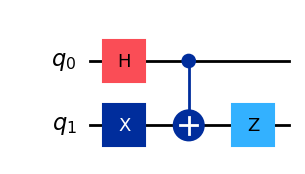

In [2124]:
def create_singlet_circuit():
    qc = QuantumCircuit(2, name="Singulett")
    # 1) X(1) => |01>
    qc.x(1)
    # 2) H(0)
    qc.h(0)
    # 3) CNOT(0->1)
    qc.cx(0, 1)
    # 4) Z(1)
    qc.z(1)
    return qc

# Erzeuge den Schaltkreis und zeige den Statevector
qc_singlet = create_singlet_circuit()
qc = qc_singlet.draw('mpl')

Wir lassen uns nun den resultierenden Statevector anzeigen. Er sollte dem $(|01\rangle - |10\rangle)/\sqrt{2}$ entsprechen.

In [2125]:
transpiled_singlet = transpile(qc_singlet, simulator)
job_sv = simulator.run(transpiled_singlet)
sv_result = job_sv.result()
psi_state = Statevector.from_instruction(qc_singlet)
print("Singulett-Zustand (amplitudenweise):", psi_state)

Singulett-Zustand (amplitudenweise): Statevector([ 0.        +0.j,  0.70710678+0.j, -0.70710678+0.j,
              0.        +0.j],
            dims=(2, 2))


<a id="bloch"></a>
## 6. Bloch-Kugel-Visualisierungen

Um den Singulettzustand zu visualisieren, kann man `plot_bloch_multivector` nutzen. Dieser Befehl zeigt typischerweise zwei Bloch-Kugeln an – eine pro Qubit. Da unser Zustand stark verschränkt ist, sind die individuellen (reduzierten) Zustände "gemischt" und erscheinen tendenziell am Ursprung.
Man kann alternativ den kompletten 2-Qubit-Zustand als Bloch-Vektor darstellen, doch für 2 Qubits wird das ggf. unübersichtlich.
Es kann außerdem hilfreich sein, die Reduktion auf einzelne Qubits separat auszurechnen und zu plotten.

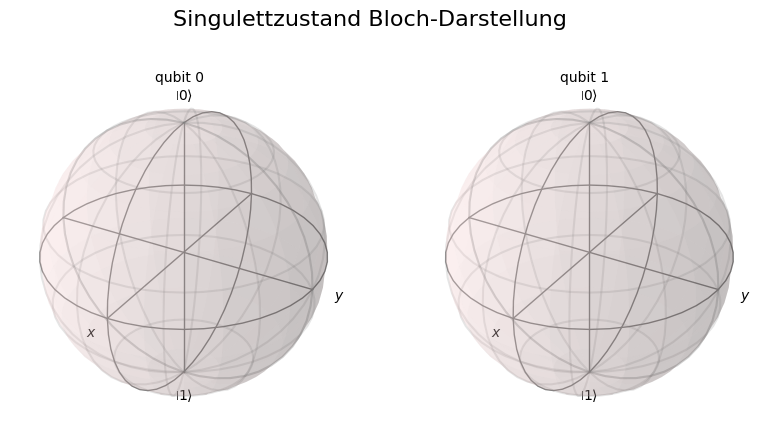

In [2126]:
bloch_sphere = plot_bloch_multivector(psi_state, title="Singulettzustand Bloch-Darstellung")

**Hinweis**

1. Doppelte Anzeige:
    - Qiskit erzeugt pro Qubit zwei Bloch-Kugeln (man kann sie als „zwei Visualisierungen“ pro Qubit verstehen), sodass du bei 2 Qubits eben vier Kugeln siehst.

2. Bloch Vektoren:
    - Durch die maximale Verschränkung ist jedes einzelne Qubit in einer gemischten (d. h. „ungeordneten“)  Teilzustand-Form.
    - Die Bloch-Kugel hat dann einen Radius von 0.
    - Es gibt schlichtweg keine „bevorzugte Ausrichtung“, also keinen sichtbaren Vektor.

Hier ist daher einmal eine Blochkugel mit einem Pfeil:

Counts: {'01': 507, '10': 517}
Korrelation: -1.0


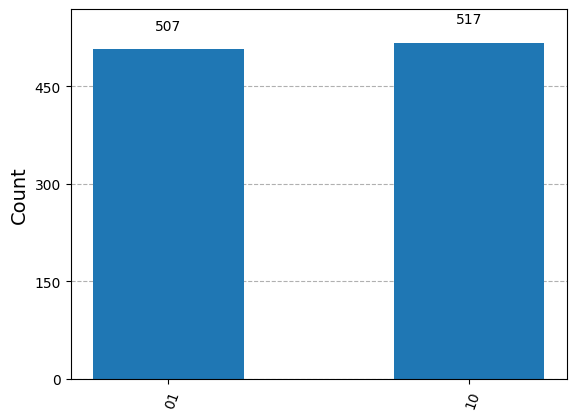

In [2127]:
qc_singlet.measure_all()

transpiled_singlet = transpile(qc_singlet, simulator)
job = simulator.run(transpiled_singlet)
result = job.result()
counts = result.get_counts()
print("Counts:", counts)
print("Korrelation:", correlation(counts))
histogram = plot_histogram(counts)

<a id="messungen"></a>
## 7. Messungen in verschiedenen Basen & CHSH-Test

Um die nicht-lokalen Korrelationen nachzuweisen (bzw. Eavesdropping zu erkennen), misst man das Bell-Paar in unterschiedlichen Basen. Ein häufig genutztes Vorgehen ist der **CHSH-Test**. Dabei misst Alice in zwei Winkeln (meist 0° und 45°) und Bob in zwei anderen Winkeln (22.5° und -22.5°), was einer bekannten Wahl für maximalen Verstoß gegen lokale Realismus-Theorien (Bell-Ungleichung) entspricht.
Der CHSH-Parameter $S$ wird aus den Erwartungswerten (Korrelationswerten) in vier Einstellungen A0-B0, A0-B1, A1-B0, A1-B1 berechnet:

$S = E(A0,B0) - E(A0,B1) + E(A1,B0) + E(A1,B1)$

Sollte $|S|$ größer als Zwei sein, dann ist die CHSH-Ungleichung verletzt.

### Beispiel: Z-Basis und X-Basis
Wir erstellen hier ein exemplarisches Messprogramm, das Qubit 0 in Z bzw. X misst und Qubit 1 in Z bzw. X, und schauen uns an, welche Korrelationen wir erhalten. (Für einen echten CHSH-Test wählt man meist Zwischendrehungen, z.B. 0°, 22.5°, 45°, etc.)

In [2128]:
# Beispiel: Qubit 0 in Z, Qubit 1 in Z

qc_test_zz = create_singlet_circuit()
qc_test_zz.measure_all()

transpiled_zz = transpile(qc_test_zz, simulator)
job_zz = simulator.run(transpiled_zz, shots=1024)
result_zz = job_zz.result()
counts_zz = result_zz.get_counts()
print("Z-Z Messung:", counts_zz)
E_zz = correlation(counts_zz)
print("Korrelationswert E(Z,Z):", E_zz)

Z-Z Messung: {'10': 506, '01': 518}
Korrelationswert E(Z,Z): -1.0


In [2129]:
# Beispiel: Qubit 0 in X messen, Qubit 1 in Z
# => Erfordert vor dem Measure(0) eine H-Operation, damit wir die X-Basis messen.

qc_test_xz = create_singlet_circuit()
qc_test_xz.h(0)  # X-Basis auf Qubit 0
qc_test_xz.measure_all()

transpiled_xz = transpile(qc_test_xz, simulator)
job_xz = simulator.run(transpiled_xz, shots=1024)
result_xz = job_xz.result()
counts_xz = result_xz.get_counts()
print("X-Z Messung:", counts_xz)
E_xz = correlation(counts_xz)
print("Korrelationswert E(X,Z):", E_xz)

X-Z Messung: {'01': 260, '11': 250, '10': 251, '00': 263}
Korrelationswert E(X,Z): 0.001953125


Analog kann man beliebige weitere Basen messen, indem man das jeweilige Qubit in die richtige Rotationslage bringt. Zum Beispiel:
- Z-Basis: Keine Vorrotation
- X-Basis: H vor dem Messen
- Y-Basis: S-Dagger $(S^\dagger)$ gefolgt von H (oder eine einzelne Drehung) vor dem Messen
usw.

In einem vollständigen CHSH-Test würde man 4 Messkreise aufbauen, wobei jeweils die Winkel A0, A1, B0, B1 realisiert werden, und dann den Parameter $S$ berechnen. Typischerweise liegt $S$ (ideal) bei ca. 2.8 für einen maximalen Verstoß.


<a id="schluessel"></a>
## 8. E91-Schlüsselerzeugung

1. Alice und Bob erhalten eine Menge verschränkter Paare im Zustand: $|\psi^-\rangle$
2. Alice misst zufällig in Basen A0 oder A1, Bob misst zufällig in Basen B0 oder B1 (siehe CHSH-Wahl). Sie notieren die Ergebnisse.
3. Sie vergleichen (einen Teil davon) öffentlich die gewählten Basen und checken die Korrelationen (CHSH). Wenn $|S| > 2$ im statistischen Rahmen, ist das System sicher.
4. Für die gleichen Basen extrahieren sie die Bit-Werte, die identisch sein sollten.
5. Eine Fehlerkorrektur und Privatsphärenamplifikation kann daraufhin angewendet werden.
6. Fertig ist der geheime (nicht-lokal geteilte) Schlüssel!

In diesem Notebook haben wir die Kernideen illustriert. Für einen vollständigen QKD-Workflow (mit allen Protokollschritten) bräuchte man natürlich noch mehr Infrastruktur, z.B. klassische Kommunikation, Abgleich der Basen, Error Correction etc.

<a id="fazit"></a>
## 9. Fazit zum E91
- Wir haben das E91-Prinzip mithilfe von **Qiskit** simuliert:
  1. **Singulett-Zustand** erzeugt
  2. **Messungen** in unterschiedlichen Basen
  3. **CHSH-Parameter** berechnet
  4. **Bloch-Kugel**-Darstellungen zur Visualisierung gezeigt.
- Das E91-Protokoll demonstriert, wie **Verschränkung** und die **Verletzung lokaler Realismus-Ungleichungen** für sicheren Schlüsselaustausch genutzt werden können.
- In einer realen QKD-Anwendung (ob E91 oder BB84) kommen noch weitere Protokollschichten hinzu: **Fehlerkorrektur** und **Privacy Amplification**.

**Weiterführende Ideen:**
- Man kann die Winkel verallgemeinern, z.B. Messungen bei 0°, 45°, 22.5°, -22.5°.
- Den **CHSH-Parameter** vollständig implementieren, indem man 4 Messkreise ausführt und am Ende $S$ berechnet.
- Visualization Tools nutzen, um Bobs und Alice' Messverteilungen/Histogramme zu zeigen.
- Noch **Noise** oder **Qubit-Fehler** einfügen (z.B. über Qiskit Noise Models), um zu sehen, wie stark das QKD-System belastet wird.

**Weitere Coding Beispiele:**
- In diesem Repository haben wir auch Coding Beispiele für den `BB84-Algorithmus` und für die Simulation von einem `Quantum Randomnumber Generator`.